# Import

In [1]:
import pandas as pd 
import numpy as np
from scipy import stats

# Data path 

In [2]:

DATA_PATH = '../loan_data/credit_risk_dataset.csv'

# Dataframe Description

| **Feature Name**                | **Description**                       |
|----------------------------------|---------------------------------------|
| `person_age`                    | Age                                   |
| `person_income`                 | Annual Income                        |
| `person_home_ownership`         | Home ownership                       |
| `person_emp_length`             | Employment length (in years)         |
| `loan_intent`                   | Loan intent                          |
| `loan_grade`                    | Loan grade                           |
| `loan_amnt`                     | Loan amount                          |
| `loan_int_rate`                 | Interest rate                        |
| `loan_status`                   | Loan status (0 is non-default, 1 is default) |
| `loan_percent_income`           | Percent income                       |
| `cb_person_default_on_file`     | Historical default                   |
| `cb_preson_cred_hist_length`    | Credit history length                |

# Analyze the data

## Load data 

In [3]:
train_data = pd.read_csv(DATA_PATH)

In [4]:
train_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
train_data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
# check the percentage of  missing values out of the total number of rows
missing_values = train_data.isnull().sum()
total_cells = np.int64(train_data.shape[0])
total_missing = missing_values.sum()
total_missing_percentage = (total_missing / total_cells) * 100
print(f'The total missing values in the dataset is {total_missing} which is {total_missing_percentage:.2f}% of the total cells')

The total missing values in the dataset is 4011 which is 12.31% of the total cells


In [8]:
# cheking the number of values missing simultaneously in loan_int_rate and person_emp_length columns
missing_values = train_data[train_data['loan_int_rate'].isnull() & train_data['person_emp_length'].isnull()].shape[0]
print(f'The number of missing values in loan_int_rate and person_emp_length columns simultaneously is {missing_values} which is {missing_values/total_cells:.5f}% of the total cells')

The number of missing values in loan_int_rate and person_emp_length columns simultaneously is 68 which is 0.00209% of the total cells


In [9]:
# 1. Drop rows with missing values in the 'person_emp_length' and loan interest rate column since it does not impact the dataset significantly
train_data = train_data.dropna(subset=['loan_int_rate', 'person_emp_length'])

## Correlation with features and target 

In [10]:
numeric_columns = train_data.select_dtypes(include=[np.number])

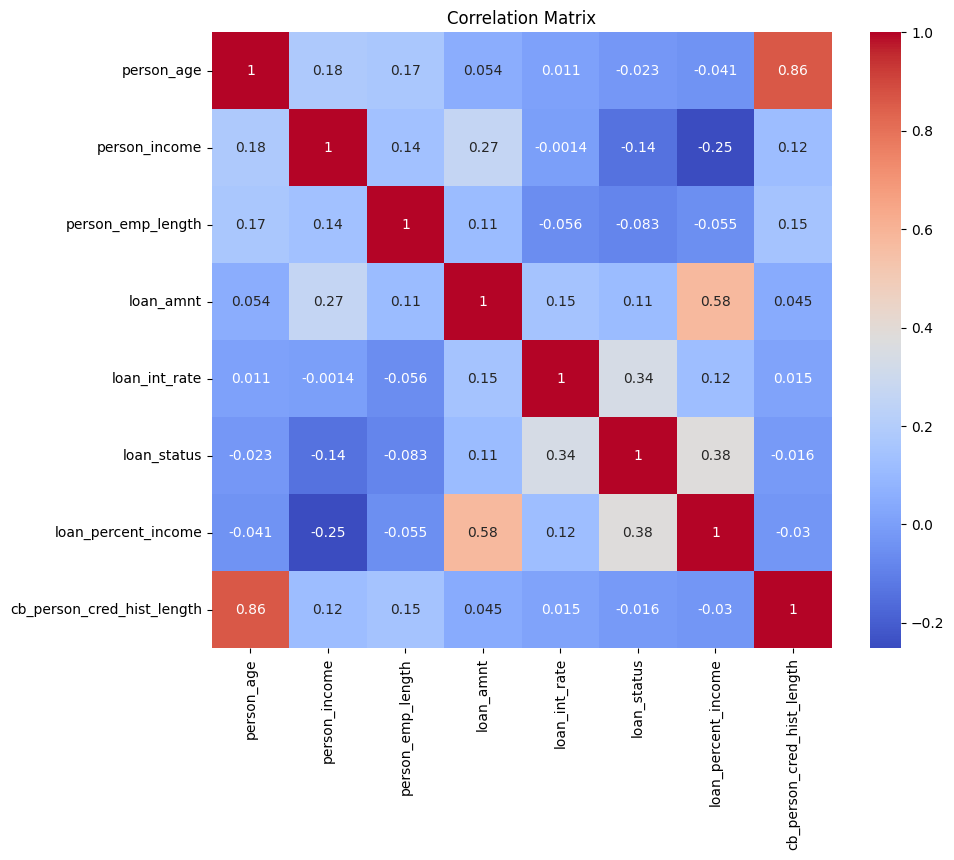

In [11]:
import seaborn as sns

# compute correlation matrix with the numeric columns and the target variable which is 'loan_status'
# and plot it in a heatmap
correlation_matrix = numeric_columns.corr()
correlation_matrix['loan_status'].sort_values(ascending=False)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

'loan_int_rate' : is an imporant data but there is no way to replace the missing data, trying to replace the data will not be accurate and can mislead the model 

'person_emp_length' : is independent and is not linked to the "loan_status" so we can also delete the rows where the data is missing 

In [12]:
# delete the rows with missing values in the 'loan_int_rate' and 'person_emp_length' columns
numeric_columns = numeric_columns.dropna(subset=['loan_int_rate', 'person_emp_length'])

In [13]:
# check the number of missing values in the numeric columns
train_data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## ANOVA test to study relationship with qualitative data and the taget

In [53]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway

In [37]:
# select the categorical data and include the loan_status column
categorical_data = train_data.select_dtypes(include=[np.object_])
categorical_data['loan_status'] = train_data['loan_status']

In [63]:
categorical_data.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,loan_status
0,RENT,PERSONAL,D,Y,1
1,OWN,EDUCATION,B,N,0
2,MORTGAGE,MEDICAL,C,N,1
3,RENT,MEDICAL,C,N,1
4,RENT,MEDICAL,C,Y,1


In [61]:
categorical_columns = categorical_data.columns.to_list()
categorical_columns.remove('loan_status')

In [62]:
for col in categorical_columns:
    grouped_data = categorical_data.groupby(col)['loan_status']
    anova_result = f_oneway(*[group for _, group in grouped_data])
    print(f"ANOVA Test for loan_status '{col}':")
    print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4f}")

ANOVA Test for loan_status 'person_home_ownership':
F-statistic: 584.4851, p-value: 0.0000
ANOVA Test for loan_status 'loan_intent':
F-statistic: 94.5366, p-value: 0.0000
ANOVA Test for loan_status 'loan_grade':
F-statistic: 1039.9232, p-value: 0.0000
ANOVA Test for loan_status 'cb_person_default_on_file':
F-statistic: 981.2437, p-value: 0.0000


All the p.value < 0.05 so the categorical variables are dependant to the target value. 

## View target repartition 

In [66]:
train_data["loan_status"].value_counts().to_frame()

,count
loan_status,
0,22435
1,6203


<Axes: xlabel='loan_status'>

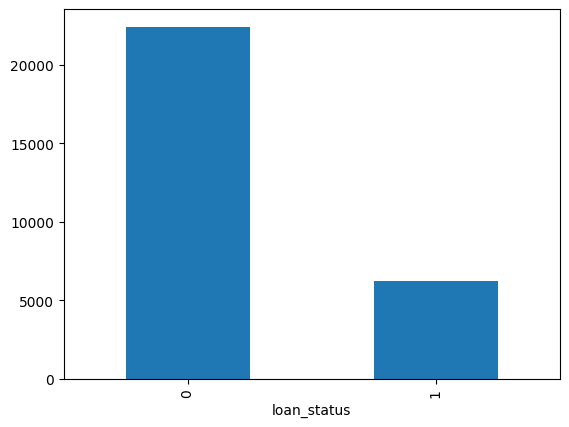

In [64]:
train_data["loan_status"].value_counts().plot(kind='bar')

training data is higly inbalanced, we will need strategies to monitor that 

##  Analysis General 

In [35]:
train_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [52]:
train_data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [54]:
# the data has a person that is 123 years old, which is not possible , lets see how many people are older than 100
train_data[train_data["person_age"] > 100]

In [ ]:
# I will remone the person that is 123 years old in the dataset 
train_data = train_data[train_data["person_age"] < 100]

<Axes: >

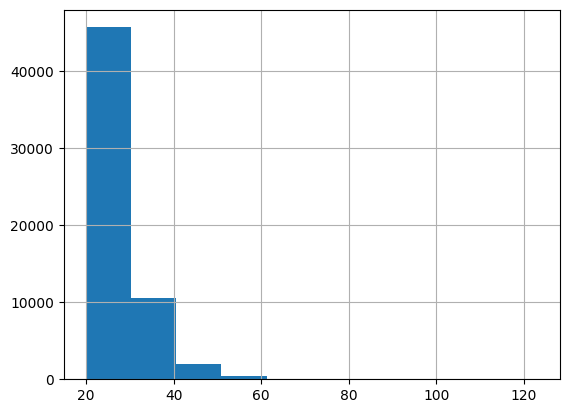

In [38]:
train_data["person_age"].hist()

<Axes: xlabel='person_age'>

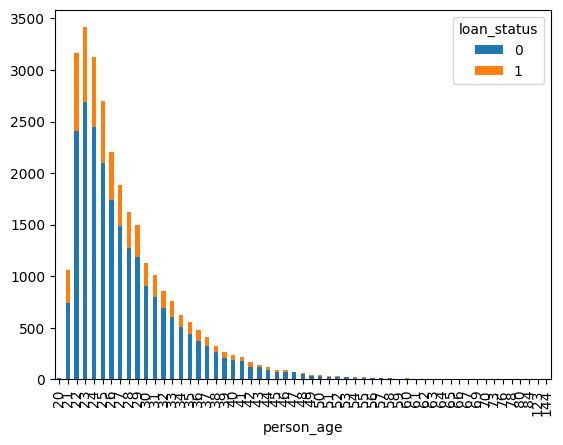

In [80]:
train_data.groupby("person_age")["loan_status"].value_counts().unstack().plot(kind='bar', stacked=True)

<Axes: xlabel='person_home_ownership'>

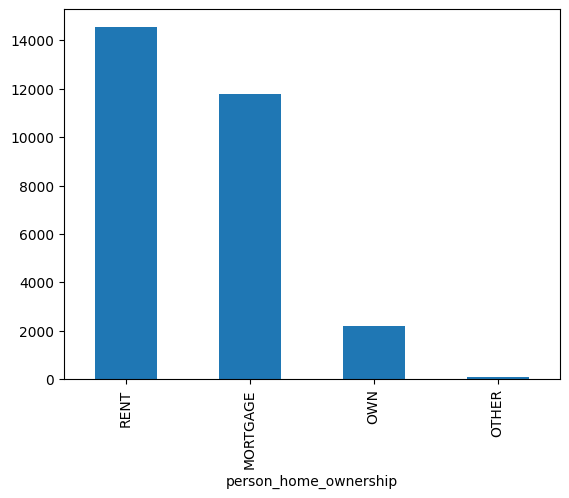

In [68]:
train_data["person_home_ownership"].value_counts().plot(kind='bar')

<Axes: xlabel='person_home_ownership'>

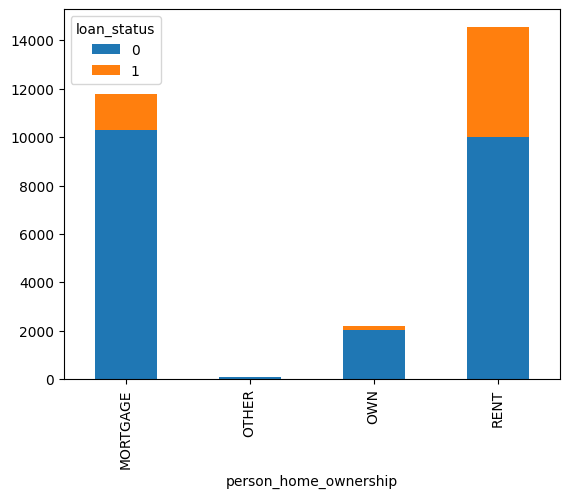

In [78]:
train_data.groupby("person_home_ownership")["loan_status"].value_counts().unstack().plot(kind='bar', stacked=True)

<Axes: xlabel='loan_intent'>

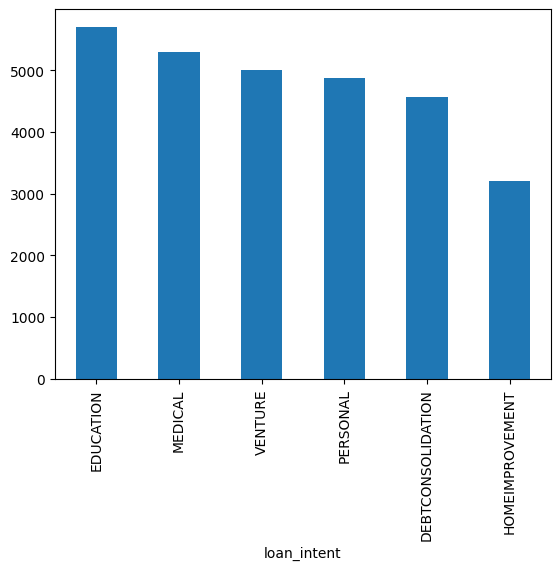

In [69]:
train_data["loan_intent"].value_counts().plot(kind='bar')

<Axes: xlabel='loan_intent'>

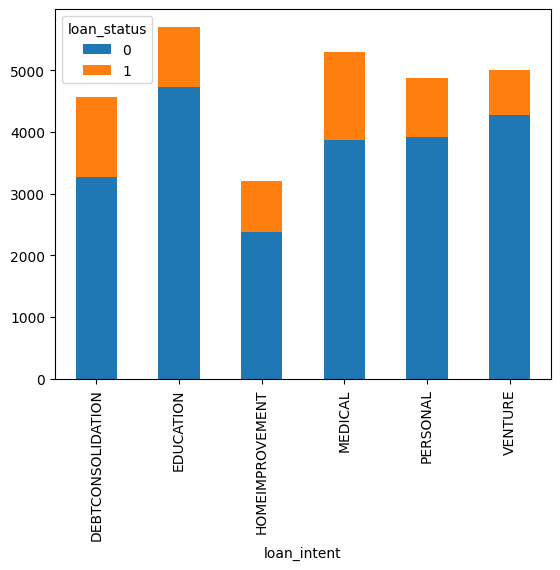

In [77]:
train_data.groupby("loan_intent")["loan_status"].value_counts().unstack().plot(kind='bar', stacked=True)

In [86]:
# group the person_income into category bins fron 0 to 500k 
train_data["person_income_category"] = pd.cut(train_data["person_income"], bins=[0, 25000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000], labels=['0-25k','25-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k-300k', '300k-350k', '350k-400k', '400k-450k', '450k-500k'])

<Axes: xlabel='person_income_category'>

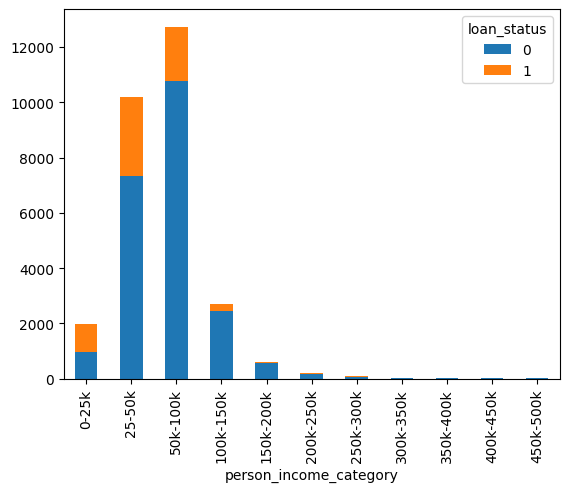

In [92]:
train_data.groupby("person_income_category", observed=True)["loan_status"] \
          .value_counts().unstack().plot(kind='bar', stacked=True)